In [3]:
# facenet_pytorch_c: avoid confusion with system default facenet_pytorch
#from facenet_pytorch_c import MTCNN

from tqdm import tqdm
import numpy as np
import os

# pytorch
import torch
from torch import nn

# data handling
from torch.utils.data import DataLoader

# torchvision libs
import torchvision
from torchvision import datasets
from torchvision import transforms
import PIL

import utils


In [4]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [5]:
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = 'cpu'
print("Available device: " + str(device))

# data loading parameters
workers = 4

Available device: cpu


In [6]:
x_t, b_prob_t, b_box_t, f_prob_t, f_box_t, x_v, b_prob_v, b_box_v, f_prob_v, f_box_v = utils.get_images(
    '/home/ubuntu/db_proc/db/images',
    '/home/ubuntu/db_proc/db/annotations',
    valid_percent=100,
    resize_shape=(400,400) # keep original size
)

100%|██████████| 3605/3605 [00:16<00:00, 224.97it/s]


v_ds size: 3605


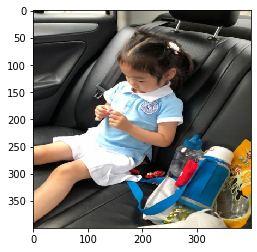

body: [ 79  25 295 277], face: [167  98 232 165]


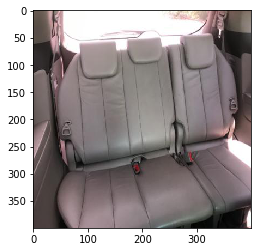

body: [0 0 0 0], face: [0 0 0 0]


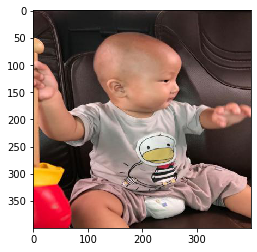

body: [ 13  39 381 357], face: [175  62 267 194]


In [7]:
print("v_ds size: {}".format(len(x_v)))
for i in range(0, 300, 100):
    plt.imshow(x_v[i])
    plt.show()
    print("body: {}, face: {}".format(b_box_v[i], f_box_v[i]))

In [8]:
class PNet(nn.Module):

    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 10, kernel_size=3)
        self.prelu1 = nn.PReLU(10)
        self.pool1 = nn.MaxPool2d(2, 2, ceil_mode=True)
        self.conv2 = nn.Conv2d(10, 16, kernel_size=3)
        self.prelu2 = nn.PReLU(16)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3)
        self.prelu3 = nn.PReLU(32)
        
        self.conv4_1 = nn.Conv2d(32, 2, kernel_size=1) # body prob
        self.softmax4_1 = nn.Softmax(dim=1)
        
        self.conv4_2 = nn.Conv2d(32, 4, kernel_size=1) # body bbox
        
        self.conv4_3 = nn.Conv2d(32, 2, kernel_size=1) # face prob
        self.softmax4_3 = nn.Softmax(dim=1)
        
        self.conv4_4 = nn.Conv2d(32, 4, kernel_size=1) # face bbox
        
        state_dict = torch.load('cd_pnet_xtradata.pt')
        #state_dict = torch.load('cd_pnet.pt')
        self.load_state_dict(state_dict)
        
        self.training = True

    def forward(self, x):
        x = self.conv1(x)
        x = self.prelu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.prelu2(x)
        x = self.conv3(x)
        x = self.prelu3(x)
        
        a = self.conv4_1(x) # body prob
        a = self.softmax4_1(a)
        
        b = self.conv4_2(x) # body bbox
        
        c = self.conv4_3(x) # face prob
        c = self.softmax4_3(c)
        
        d = self.conv4_4(x) # face bbox
        
        return a, b, c, d


In [10]:
class BNet(nn.Module):

    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3)
        self.prelu1 = nn.PReLU(32)
        self.pool1 = nn.MaxPool2d(3, 2, ceil_mode=True)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.prelu2 = nn.PReLU(64)
        self.pool2 = nn.MaxPool2d(3, 2, ceil_mode=True)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3)
        self.prelu3 = nn.PReLU(64)
        self.pool3 = nn.MaxPool2d(2, 2, ceil_mode=True)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=2)
        self.prelu4 = nn.PReLU(128)
        self.dense5 = nn.Linear(1152, 256)
        self.prelu5 = nn.PReLU(256)
        
        self.dense6_1 = nn.Linear(256, 2)    # body prob
        self.softmax6_1 = nn.Softmax(dim=1)
        
        self.dense6_2 = nn.Linear(256, 4)    # body bbox
        
        state_dict = torch.load('bnet.pt')
        self.load_state_dict(state_dict)

        self.training = True

    def forward(self, x):
        x = self.conv1(x)
        x = self.prelu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.prelu2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.prelu3(x)
        x = self.pool3(x)
        x = self.conv4(x)
        x = self.prelu4(x)
        x = self.dense5(x.view(x.shape[0], -1))
        x = self.prelu5(x)
        a = self.dense6_1(x)
        a = self.softmax6_1(a)
        b = self.dense6_2(x)
        return a, b


In [11]:
pnet, bnet = PNet(), BNet()
pnet.eval()
bnet.eval()
pnet.to(device);
bnet.to(device);

# of images in pyramid: 11


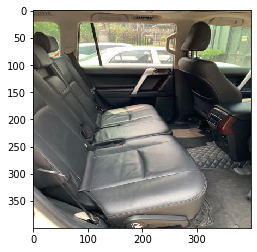

1.00


In [81]:
import PIL
from PIL import Image

# paramters
idx = 7
factor = 0.709
#factor = 0.502681
thrs = [0.6, 0.8]

o_img = x_v[idx]
o_width, o_height = o_img.size
t_scale = 1

ipymd, spymd = [], [] # image pyramid & corresponding scales

while min(o_width, o_height) >= 12:
    
    ipymd.append(o_img)
    spymd.append(t_scale)
    
    t_scale *= factor
    o_width *= factor
    o_height *= factor
    o_img = o_img.resize((int(round(o_width)), int(round(o_height))), Image.LANCZOS)

o_img = ipymd[0]
o_width, o_height = o_img.size

if True:
    print("# of images in pyramid: {}".format(len(ipymd)))
    for i, s in zip(ipymd, spymd):
        plt.imshow(i)
        plt.show()
        print("{:.2f}".format(s))
        break


In [82]:
# run PNet over image pyramid

lastn = -6

with torch.no_grad():
    bp, bb, fp, fb = [], [], [], []

    for img, scale in zip(ipymd[lastn:], spymd[lastn:]):

        # unsqueeze: add 1 extra "batch" dimension to image
        img = transforms.ToTensor()(img).unsqueeze(0).to(device)
        obp, obb, ofp, ofb  = pnet(img)

        # tensor.shape = (..., height, width)

        obp, obb, ofp, ofb = obp.squeeze(), obb.squeeze(), ofp.squeeze(), ofb.squeeze()
        
        obp, ofp = obp[0, :], ofp[0, :]  # remove the dimension indicating probability of no body/face

        bp_mask, fp_mask = obp >= thrs[0], ofp >= thrs[0]
        bpm_inds, fpm_inds = bp_mask.nonzero(), fp_mask.nonzero()
        obp, obb, ofp, ofb = obp[bp_mask], obb[:, bp_mask], ofp[fp_mask], ofb[:, fp_mask]

        obb, ofb = obb.permute(1, 0), ofb.permute(1, 0)
        
        obb[:, 0] = (obb[:, 0] + bpm_inds[:, 1] * 2) / scale
        obb[:, 1] = (obb[:, 1] + bpm_inds[:, 0] * 2) / scale
        obb[:, 2] = (obb[:, 2] + bpm_inds[:, 1] * 2) / scale
        obb[:, 3] = (obb[:, 3] + bpm_inds[:, 0] * 2) / scale

        """
        for i in range(0, len(obb)):
            obb[i][0] = (obb[i][0] + bpm_inds[i][1] * 2) / scale
            obb[i][1] = (obb[i][1] + bpm_inds[i][0] * 2) / scale
            obb[i][2] = (obb[i][2] + bpm_inds[i][1] * 2) / scale
            obb[i][3] = (obb[i][3] + bpm_inds[i][0] * 2) / scale
        """ 
        ofb[:, 0] = (ofb[:, 0] + fpm_inds[:, 1] * 2) / scale
        ofb[:, 1] = (ofb[:, 1] + fpm_inds[:, 0] * 2) / scale
        ofb[:, 2] = (ofb[:, 2] + fpm_inds[:, 1] * 2) / scale
        ofb[:, 3] = (ofb[:, 3] + fpm_inds[:, 0] * 2) / scale

        """
        for i in range(0, len(ofb)):
            ofb[i][0] = (ofb[i][0] + fpm_inds[i][1] * 2) / scale
            ofb[i][1] = (ofb[i][1] + fpm_inds[i][0] * 2) / scale
            ofb[i][2] = (ofb[i][2] + fpm_inds[i][1] * 2) / scale
            ofb[i][3] = (ofb[i][3] + fpm_inds[i][0] * 2) / scale
        """
        bp.append(obp)
        bb.append(obb)
        fp.append(ofp)
        fb.append(ofb)

    t_bp = torch.Tensor(len(bp))
    t_bb = torch.Tensor(len(bb), 4)
    t_fp = torch.Tensor(len(fp))
    t_fb = torch.Tensor(len(fb), 4)

    torch.cat(bp, out=t_bp)
    torch.cat(bb, out=t_bb)
    torch.cat(fp, out=t_fp)
    torch.cat(fb, out=t_fb)


# of body preds: 12


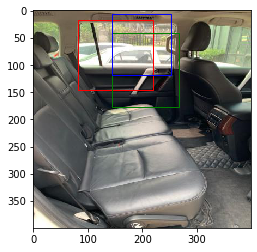

In [83]:
bids = torchvision.ops.nms(t_bb, t_bp, 0.5)
fids = torchvision.ops.nms(t_fb, t_fp, 0.5)

bps = t_bp[bids].numpy()
bbs = t_bb[bids].numpy()

fps = t_fp[fids].numpy()
fbs = t_fb[fids].numpy()

clr = ['r', 'g', 'b', 'w', 'y']
cid = 0

# show body boxes
if True:
    fig,ax = plt.subplots(1)
    ax.imshow(ipymd[0])

    print("# of body preds: {}".format(len(bbs)))
    for i, p in zip(bbs, bps):
        if i[2]-i[0] < 90 or i[3]-i[1] < 90:
            continue
        rect = patches.Rectangle((i[0],i[1]),i[2]-i[0],i[3]-i[1],linewidth=1,edgecolor=clr[cid],facecolor='none')
        ax.add_patch(rect)
        #print("color: {}; prob: {:.2f}".format(clr[cid], p))
        cid += 1
        cid %= len(clr)
    plt.show()

# show face boxes
if False:
    fig,ax = plt.subplots(1)
    ax.imshow(ipymd[0])
    
    print("# of face preds: {}".format(len(fbs)))
    for i, p in zip(fbs, fps):
        rect = patches.Rectangle((i[0],i[1]),i[2]-i[0],i[3]-i[1],linewidth=1,edgecolor=clr[cid],facecolor='none')
        ax.add_patch(rect)
        #print("color: {}; prob: {:.2f}".format(clr[cid], p))
        cid += 1
        cid %= len(clr)
    plt.show()

In [84]:
# convert bbox output of PNet to squares, and expand them by 10px in each direction
epad = 25
po_b, po_f = [], []

for i in range(0, len(bbs)):
    cw = bbs[i, 2] - bbs[i, 0]
    ch = bbs[i, 3] - bbs[i, 1]
    diff = int(round(abs(cw-ch)/2))
    if True:
        if cw > ch:
            bbs[i, 1] -= diff
            bbs[i, 3] += diff
        else:
            bbs[i, 0] -= diff
            bbs[i, 2] += diff
    crp = o_img.crop((bbs[i,0]-epad, bbs[i,1]-epad, bbs[i,2]+epad, bbs[i,3]+epad))
    po_b.append(crp)
    if False:
        plt.imshow(crp)
        plt.show()


In [85]:
for i in range(0, len(fbs)):
    cw = fbs[i, 2] - fbs[i, 0]
    ch = fbs[i, 3] - fbs[i, 1]
    diff = int(round(abs(cw-ch)/2))
    if True:
        if cw > ch:
            fbs[i, 1] -= diff
            fbs[i, 3] += diff
        else:
            fbs[i, 0] -= diff
            fbs[i, 2] += diff
    crp = o_img.crop((fbs[i,0]-epad, fbs[i,1]-epad, fbs[i,2]+epad, fbs[i,3]+epad))
    po_f.append(crp)
    if False:
        plt.imshow(crp)
        plt.show()

In [86]:
po_b = [k.resize((48,48), Image.LANCZOS) for k in po_b]
po_f = [k.resize((48,48), Image.LANCZOS) for k in po_f]

In [87]:

# unsqueeze: add 1 extra "batch" dimension to image
imgs = [transforms.ToTensor()(k).to(device) for k in po_b]
imgs = torch.stack(imgs) # stack all possible body images into 1 tensor (batch process)

obp, obb = bnet(imgs) # ignore output about face (since all these are potential "body" regions)

#obp, obb = obp.squeeze(), obb.squeeze()
obp = obp[:, 0] # remove dimension for "negative" probability (and keep batch dimension)

bp_mask = obp >= thrs[1]
#bpm_inds = bp_mask.nonzero()
obp, obb, imgs = obp[bp_mask], obb[bp_mask, :], imgs[bp_mask, :]
keep_inds = torchvision.ops.nms(obb, obp, 0.3)
obb, obp = obb[keep_inds].detach().numpy(), obp[keep_inds].detach().numpy()

imgs = imgs[keep_inds]
imgs = [torchvision.transforms.ToPILImage()(k) for k in imgs]

print("detected body numbers: {}".format(len(imgs)))
for k, b in zip(imgs, obb):
    fig,ax = plt.subplots(1)
    ax.imshow(k)
    rect = patches.Rectangle((b[0],b[1]),b[2]-b[0],b[3]-b[1],linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
    plt.show()
    print("bbox: {}".format(b.round(0)))

detected body numbers: 0


color: r; prob: 0.91
color: g; prob: 0.82
color: b; prob: 0.80
color: w; prob: 0.70
color: y; prob: 0.69
color: r; prob: 0.66
color: g; prob: 0.66
color: b; prob: 0.61


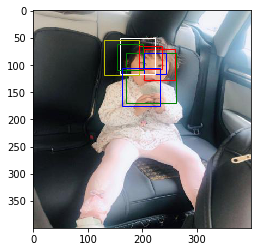

In [19]:
fig,ax = plt.subplots(1)
ax.imshow(ipymd[0])

clr = ['r', 'g', 'b', 'w', 'y']
cid = 0

for i, p in zip(fbs, fps):
    rect = patches.Rectangle((i[0],i[1]),i[2]-i[0],i[3]-i[1],linewidth=1,edgecolor=clr[cid],facecolor='none')
    ax.add_patch(rect)
    print("color: {}; prob: {:.2f}".format(clr[cid], p))
    cid += 1
    cid %= len(clr)
plt.show()